In [1]:
"""
Demonstrate the effect of autapse parameters on the AHP waveform after a spike.

We could maybe correlate autapse variables to degree of this effect - e.g. the 
degree of divergence from the non-autaptic AHP.

"""

'\nDemonstrate the effect of autapse parameters on the AHP waveform after a spike.\n\nWe could maybe correlate autapse variables to degree of this effect - e.g. the \ndegree of divergence from the non-autaptic AHP.\n\n'

In [2]:
# append AQUA directory to sys.path
import sys
import os
sys.path.append("..\\") # parent directory
from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from plotting_functions import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import pickle
from tqdm import tqdm   # for a progress bar
import seaborn as sns
sns.set_theme(style = "white")

# local imports
import CLI
import CF
from functions import *

In [69]:
def create_AHP(params, base_current, x_ini):
    """
    Generate a plot to show how the AHP is affected by different autapse parameters
    Args:
        params:     list of dictionaries
    Returns:
        fig, ax     matplotlib plot

    """

    T = 0.2     # s
    dt = 0.1    # ms
    N_iter = int(1000*T/dt)

    N_neurons = np.shape(params)[0]

    I_inj = base_current * np.ones((N_neurons, N_iter))

    # initial conditions
    x_start = np.full((N_neurons, 3), fill_value = x_ini)
    t_start = np.zeros(N_neurons)

    #define batch
    batch = batchAQUA(params)
    batch.Initialise(x_start, t_start)

    X, Time, spikes = batch.update_batch(dt, N_iter, I_inj)

    print(np.shape(X))

    start_time = spikes[0, 0] - 100     # the time to start each plot.
    start_idx = int(start_time/dt)

    # first compare across different f - e and tau are constant
    param_df = pd.DataFrame(params)
    sub_df = param_df[(param_df['e'] == 0.2) & (param_df['tau']== 0)].sort_values(by=['f'])
    print(sub_df['f'])
    idx = sub_df.index
    print(idx)
    cmap = 'bwr'

    fig, ax = plot_AHP(X, Time, sub_df, idx, 'f', start_idx, cmap)
    fig.suptitle("AHP with different autapses ordered \nby peak autaptic current", fontsize = 20)
    ax.set_title(f"e: {0.2} /ms, tau: {0.0} ms", fontsize = 16)
    plt.show()

    # compare different e - f and tau are constant
    param_df = pd.DataFrame(params)
    sub_df = param_df[(param_df['f'] == 150) & (param_df['tau']== 0)].sort_values(by=['e'])
    print(sub_df['e'])
    idx = sub_df.index
    print(idx)
    cmap = 'plasma'

    fig, ax = plot_AHP(X, Time, sub_df, idx, 'e', start_idx, cmap)
    fig.suptitle("AHP with different autapses ordered \nby autaptic decay constant", fontsize = 20)
    ax.set_title(f"f: {150} pA, tau: {0.0} ms", fontsize = 16)
    plt.show()

    # compare different tau - f and e are constant
    param_df = pd.DataFrame(params)
    sub_df = param_df[(param_df['f'] == 150) & (param_df['e']== 0.2)].sort_values(by=['tau'])
    print(sub_df['tau'])
    idx = sub_df.index
    print(idx)
    cmap = 'YlOrRd'

    fig, ax = plot_AHP(X, Time, sub_df, idx, 'tau', start_idx, cmap)
    fig.suptitle("AHP with different autapses ordered \nby autaptic time delay", fontsize = 20)
    ax.set_title(f"f: {150} pA, e: {0.2} /ms", fontsize = 16)
    plt.show()
    


def plot_AHP(X, T, sub_df, indices, param_name, start_idx, cmap):

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    arr = sub_df[param_name].values

    # get discrete values of colormap
    cont_cmap = plt.colormaps[cmap]
    colors = cont_cmap(np.linspace(0, 1, len(indices)))

    for n, i in enumerate(indices):
        ax.plot(T[i, :],X[i, 0, :], color = colors[n], label = arr[n])

    # plot non-autaptic neuron
    ax.plot(T[0, :], X[0, 0, :], c = 'black', label = 'no autapse')
    ax.set_xlabel("Time [ms]", fontsize = 16)
    ax.set_ylabel("Membrane Potential [mV]", fontsize = 16)
    plt.legend()

    return fig, ax

    



In [70]:
# param
RS = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
     'a': 0.03, 'b': -2, 'c': -50, 'd': 100, 'e': 0.0, 'f': 0.0, 'tau': 0.0}    # Class 1

f_vals = np.arange(-250, 251, 50)
idx_0 = np.argwhere(f_vals == 0)
f_vals = f_vals[np.r_[0:idx_0, idx_0+1:len(f_vals)]]
e_vals = np.arange(0.1, 0.5, 0.1)
tau_vals = np.array([0, 0.5, 2, 4])

params = []
params.append(RS)
for f in f_vals:
    for e in e_vals:
        for tau in tau_vals:
            temp_dict = RS.copy()
            temp_dict['f'] = f
            temp_dict['e'] = e
            temp_dict['tau'] = tau
            params.append(temp_dict)

# NOW params contains all the parameter values we need.
print(len(params))

threshold, x_ini = find_threshold(params[0], np.linspace(0, 500, 100), 2, 0.1)
base_current = threshold + 10

161


100%|██████████| 19999/19999 [00:03<00:00, 5305.05it/s]


100%|██████████| 1999/1999 [00:00<00:00, 4052.15it/s]


(161, 3, 2000)
5     -250.0
21    -200.0
37    -150.0
53    -100.0
69     -50.0
85      50.0
101    100.0
117    150.0
133    200.0
149    250.0
Name: f, dtype: float64
Index([5, 21, 37, 53, 69, 85, 101, 117, 133, 149], dtype='int64')


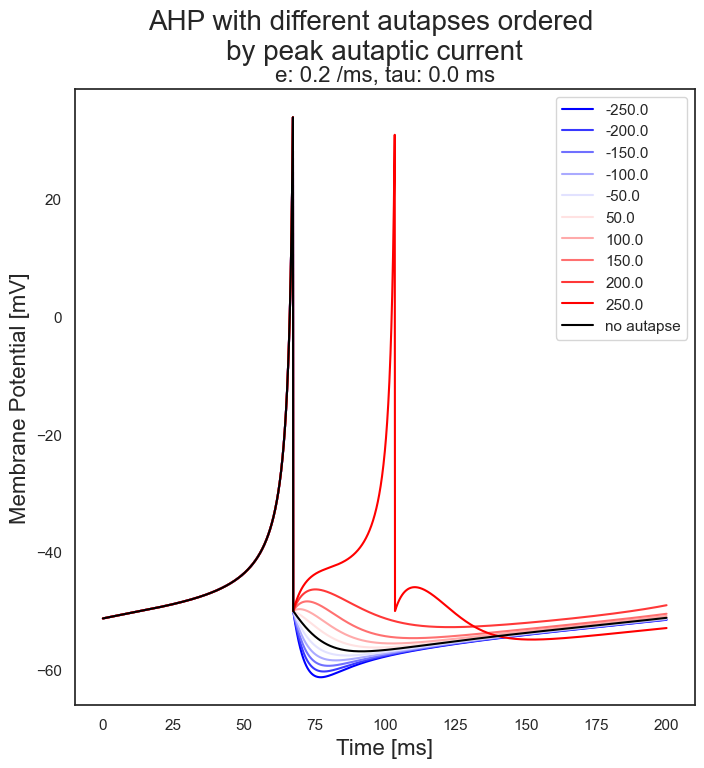

113    0.1
117    0.2
121    0.3
125    0.4
Name: e, dtype: float64
Index([113, 117, 121, 125], dtype='int64')


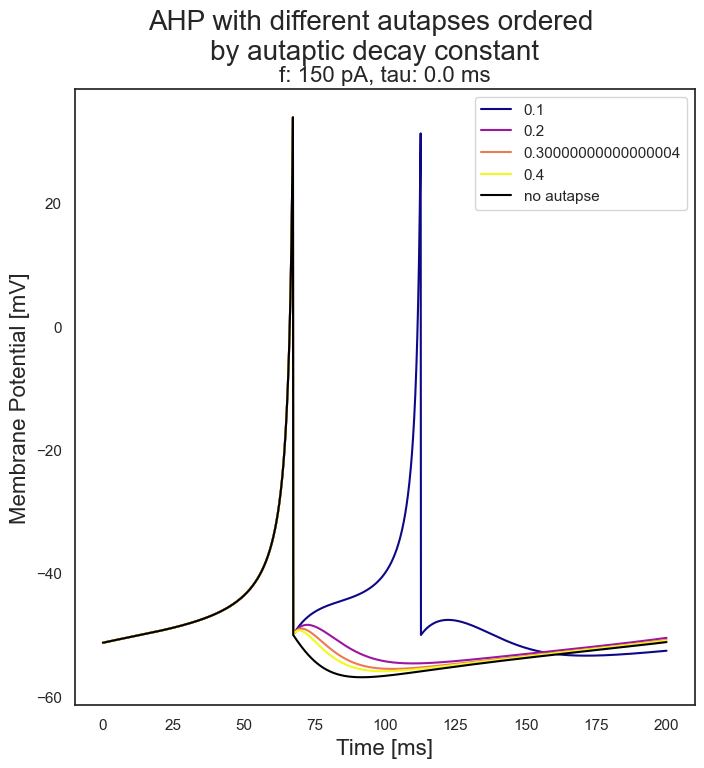

117    0.0
118    0.5
119    2.0
120    4.0
Name: tau, dtype: float64
Index([117, 118, 119, 120], dtype='int64')


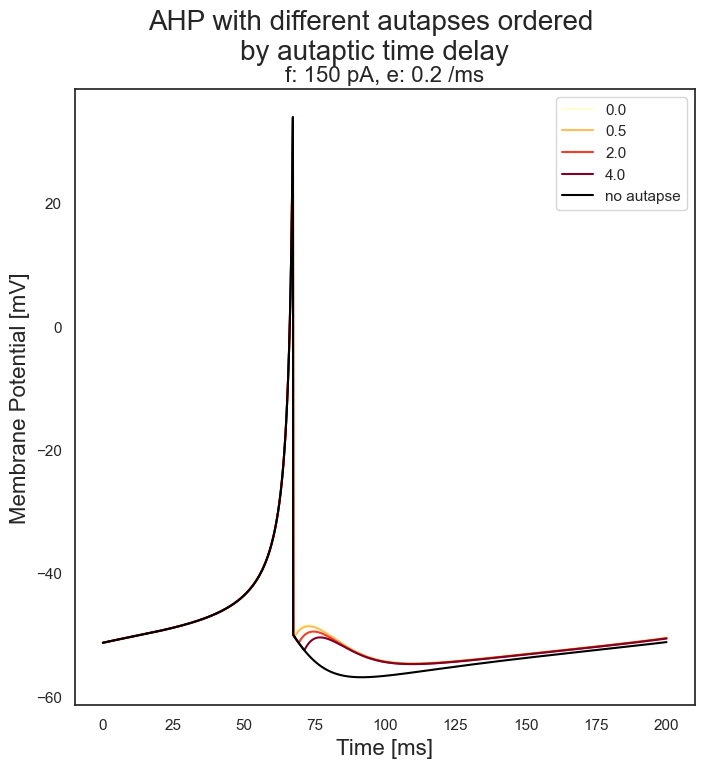

In [71]:
create_AHP(params, base_current, x_ini)